### **Initial Setup**

In [136]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras.utils import to_categorical

In [137]:
print(tf.__version__)

2.14.0


### **Importing Image Details (Cars)**

In [138]:
cars_folder = "datasets/Car Counting.v1i.coco/"

In [139]:
from pycocotools.coco import COCO

cars_info_train = cars_folder + "train/_annotations.coco.json"
cars_COCO_train = COCO(cars_info_train)

cars_info_test = cars_folder + "test/_annotations.coco.json"
cars_COCO_test = COCO(cars_info_test)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [140]:
imgIds = cars_COCO_train.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = cars_COCO_train.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=cars_COCO_train.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=cars_COCO_train.loadAnns(cars_COCO_train.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann[0])

Total images: 5536
Image example:
{'id': 1139, 'license': 1, 'file_name': 'DOH_mp4-27_jpg.rf.0b32c8265573e248cadf140d70da647a.jpg', 'height': 416, 'width': 416, 'date_captured': '2023-07-16T10:33:59+00:00'}

Total annotations: 31431
Annotation example:
{'id': 6248, 'image_id': 1139, 'category_id': 9, 'bbox': [89, 210, 57.5, 117.5], 'area': 6756.25, 'segmentation': [], 'iscrowd': 0}


In [141]:
car_categories = cars_COCO_train.loadCats(cars_COCO_train.getCatIds())
print("Number of categories: {}".format(len(car_categories)))
cars_kinds = [category['name'] for category in car_categories]
print('\nCOCO categories: \n{}\n'.format(' '.join(cars_kinds)))

Number of categories: 11

COCO categories: 
cc Bus Motorcyecle Pickup SUV Sedan Suv TRUCK TUCK Truck Van



### **Setting Up Dataframes**

In [142]:
ann_ids = cars_COCO_train.getAnnIds()

annotations_list = cars_COCO_train.loadAnns(ann_ids[0:len(ann_ids)])

annotations_df = pd.DataFrame(annotations_list)
annotations_df = annotations_df.drop(["segmentation", "area", "iscrowd"], axis=1)

In [143]:
annotations_df

,id,image_id,category_id,bbox
0,0,0,6,"[102, 150, 35, 43.5]"
1,1,0,5,"[162, 163, 21.5, 24]"
2,2,0,5,"[133, 169, 21.5, 18]"
3,3,0,3,"[147, 223, 35.5, 43]"
4,4,1,9,"[88, 110, 66, 58]"
...,...,...,...,...
31426,31426,5535,5,"[227, 269, 25, 39.5]"
31427,31427,5535,10,"[10, 280, 36.5, 34.5]"
31428,31428,5535,3,"[149, 268, 33, 60.5]"
31429,31429,5535,6,"[10, 303, 38, 42.5]"


In [144]:
image_ids = cars_COCO_train.getImgIds()

image_list = cars_COCO_train.loadImgs(imgIds[0:len(image_ids)])

image_df = pd.DataFrame(image_list)
image_df = image_df.drop(["date_captured", "license"], axis=1)
image_df.rename(columns={'id':'image_id'}, inplace=True)

In [145]:
image_df

,image_id,file_name,height,width
0,0,DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
1,1,DOH--video-converter_com-_mp4-29_jpg.rf.1bb791...,416,416
2,2,DOH_mp4-15_jpg.rf.1bca0d965b9c7bdf418f144f385e...,416,416
3,3,DOH_12_mp4-1_jpg.rf.1bab660cb143eedf004f4f4594...,416,416
4,4,DOH_mp4-13_jpg.rf.1bf23eb96868d1d271d4e44f6229...,416,416
...,...,...,...,...
5531,5531,DOH_4_mp4-18_jpg.rf.9d790097613dad0b42d71db69c...,416,416
5532,5532,DOH_3_mp4-18_jpg.rf.9cf78475ac7f2f6ff2be5381bd...,416,416
5533,5533,DOH_7_mp4-1_jpg.rf.9bb67a2bc97408e3bd27c431bab...,416,416
5534,5534,DOH_3_mp4-18_jpg.rf.9d72f5ebc6892fa37a04bf02c1...,416,416


### **Setting Up Training Data**

In [146]:
image_to_annotations_df = annotations_df["image_id"].value_counts().sort_index().reset_index() # https://stackoverflow.com/questions/35893176/how-to-assign-a-value-count-output-to-a-dataframe
image_to_annotations_df.columns=["image_id", "vehicle_count"]

In [147]:
image_to_annotations_df

,image_id,vehicle_count
0,0,4
1,1,6
2,2,5
3,3,2
4,4,6
...,...,...
5531,5531,3
5532,5532,4
5533,5533,7
5534,5534,5


In [148]:
vehicle_count = [i for i in image_to_annotations_df.vehicle_count]
image_df.insert(4, "vehicle_count", vehicle_count)

In [149]:
image_and_annotations_df = pd.merge(annotations_df, image_df, on="image_id")
image_and_annotations_df.drop(["vehicle_count"], axis=1)

,id,image_id,category_id,bbox,file_name,height,width
0,0,0,6,"[102, 150, 35, 43.5]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
1,1,0,5,"[162, 163, 21.5, 24]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
2,2,0,5,"[133, 169, 21.5, 18]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
3,3,0,3,"[147, 223, 35.5, 43]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
4,4,1,9,"[88, 110, 66, 58]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb791...,416,416
...,...,...,...,...,...,...,...
31426,31426,5535,5,"[227, 269, 25, 39.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31427,31427,5535,10,"[10, 280, 36.5, 34.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31428,31428,5535,3,"[149, 268, 33, 60.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31429,31429,5535,6,"[10, 303, 38, 42.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416


### **Setting Up Testing Data**

In [150]:
ann_test_ids = cars_COCO_test.getAnnIds()

annotations_test_list = cars_COCO_test.loadAnns(ann_test_ids[0:len(ann_test_ids)])

annotations_test_df = pd.DataFrame(annotations_test_list)
annotations_test_df = annotations_test_df.drop(["segmentation", "area", "iscrowd"], axis=1)

In [151]:
image_test_ids = cars_COCO_test.getImgIds()

image_test_list = cars_COCO_test.loadImgs(image_test_ids[0:len(image_test_ids)])

image_test_df = pd.DataFrame(image_test_list)
image_test_df = image_test_df.drop(["date_captured", "license"], axis=1)
image_test_df.rename(columns={'id':'image_id'}, inplace=True)

In [152]:
cars_y_test = annotations_test_df["category_id"][0:300]

cars_y_test = to_categorical(cars_y_test) # change category_id into one-hot encoding

### **Extracting Cars from Images**

Source: https://www.kaggle.com/code/aryankansal2019/face-mask-detection-classsifier-using-cnn

In [153]:
from PIL import Image

def crop_image(image_path, bbox):
  img = Image.open(image_path)

  left, top, width, height = bbox
  cropped = img.crop((left, top, left + width, top + height))

  return cropped

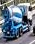

In [154]:
crop_image(cars_folder + "train/DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg", annotations_df["bbox"][0])

In [155]:
def extract_cars(image_name, dataframe):
  cars_image = []

  df_one_img = dataframe[dataframe['file_name'] == image_name]["bbox"]

  path = cars_folder + "train/" + image_name
  for row in df_one_img:
    img = crop_image(path, row)
    cars_image.append(img)

  return cars_image

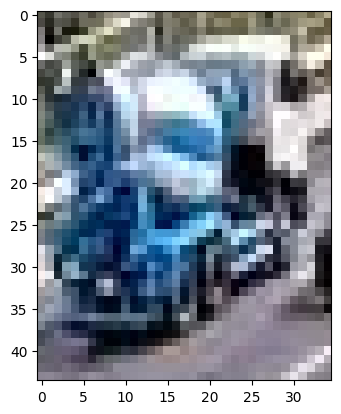

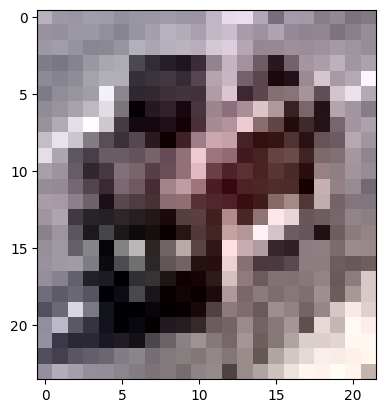

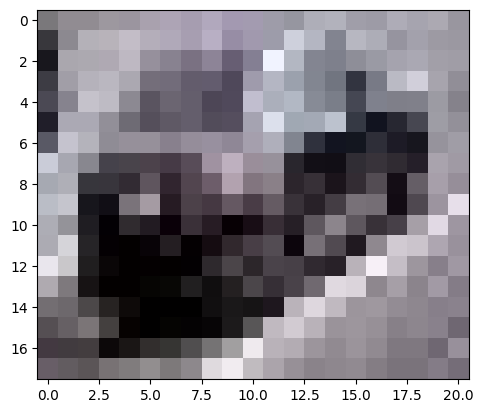

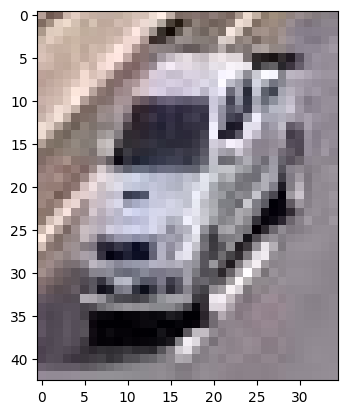

In [156]:
for i in extract_cars("DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg", image_and_annotations_df):
  plt.figure()
  plt.imshow(i)

In [157]:
# Extraction of images is done locally as it takes so long to do in colab

# cropped_images = [extract_cars(img, image_and_annotations_df) for img in image_df["file_name"]]

# ctr = 0

# for arr in cropped_images:
#   for img in arr:
#     height, width = img.height, img.width
#     max_size = max(height, width)
#     r = max_size / 128
#     new_width = int(width / r)
#     new_height = int(height / r)
#     new_size = (new_width, new_height)
#  
#     img = img.resize(new_size, Image.Resampling.LANCZOS)
# 
#     new_img = np.zeros((128, 128, 3), dtype=np.uint8)
#     new_img[0:new_height, 0:new_width] = img
#     new_img = Image.fromarray(new_img)
#     new_img.save(f"extracted_resized_train/{ctr}.jpg")
#
#     ctr += 1



In [158]:
extracted_cars_folder = "datasets/train_2100_128x128"
extracted_cars_valid = "datasets/valid_600_128x128"
extracted_cars_test = "datasets/test_300_128x128"

### **Preprocessing Train and Valid Datasets**

In [159]:
import os

img_size = 128

def load_images_from_folder(folder_path):
  images = []
  for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)
    image = tf.keras.utils.load_img(img_path)
    imageArr = np.asarray(image) / 255.0 # change values from 0-255 to 0-1
    images.append(imageArr)
  return images

In [160]:
# Labels

cars_y_train = annotations_df["category_id"][0:2100]
cars_y_valid = annotations_df["category_id"][2100:2700]
cars_y_test = annotations_test_df["category_id"][0:300]

In [161]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = datagen.flow_from_directory(
    directory=extracted_cars_folder, 
    classes=list(map(str, list(range(11)))),
    target_size = (128,128),
    class_mode="categorical", batch_size=32, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    classes=list(map(str, list(range(11)))),
    directory=extracted_cars_valid, 
    target_size = (128,128),
    class_mode="categorical", batch_size=32, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    classes=list(map(str, list(range(11)))),
    directory=extracted_cars_test, 
    target_size = (128,128),
    class_mode="categorical", batch_size=32, shuffle=False
)

Found 2100 images belonging to 11 classes.
Found 600 images belonging to 11 classes.
Found 300 images belonging to 11 classes.


### **Setting Up Model**

In [162]:
img_size = 128
batch_size = 50

input_shape = (img_size, img_size, 3)
output_shape = 11 # how many categories

In [163]:
import tensorflow as tf
import tensorflow_hub as hub

model_mobilenet = tf.keras.Sequential([
    hub.KerasLayer('https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2',
                  trainable=True, input_shape=[128, 128, 3]),
    tf.keras.layers.Dense(11, activation='softmax'),
])

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Recall', 'Precision', 'AUC'])

model_mobilenet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense_4 (Dense)             (None, 11)                14091     
                                                                 
Total params: 424299 (1.62 MB)
Trainable params: 410219 (1.56 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


### **Training the Model**

In [164]:
# model_mobilenet_history = model_mobilenet.fit_generator(
#     generator=train_generator,
#     epochs=10,
#     shuffle=True,
#     validation_data=val_generator,
# )
import scipy

model_mobilenet_history = model_mobilenet.fit(
    train_generator,
    epochs=100,
    shuffle=True,
    validation_data=val_generator,
)

Epoch 1/100
66/66 [==============================] - 28s 293ms/step - loss: 1.5881 - accuracy: 0.4714 - recall: 0.2505 - precision: 0.5970 - auc: 0.8711 - val_loss: 1.2924 - val_accuracy: 0.5400 - val_recall: 0.3600 - val_precision: 0.6017 - val_auc: 0.9210
Epoch 2/100
66/66 [==============================] - 21s 315ms/step - loss: 1.1361 - accuracy: 0.6000 - recall: 0.4567 - precision: 0.6821 - auc: 0.9388 - val_loss: 1.1581 - val_accuracy: 0.5933 - val_recall: 0.4300 - val_precision: 0.6649 - val_auc: 0.9364
Epoch 3/100
66/66 [==============================] - 23s 356ms/step - loss: 1.0084 - accuracy: 0.6343 - recall: 0.5200 - precision: 0.7285 - auc: 0.9525 - val_loss: 1.0476 - val_accuracy: 0.6283 - val_recall: 0.5433 - val_precision: 0.6878 - val_auc: 0.9476
Epoch 4/100
66/66 [==============================] - 21s 312ms/step - loss: 0.9422 - accuracy: 0.6643 - recall: 0.5629 - precision: 0.7514 - auc: 0.9584 - val_loss: 0.9933 - val_accuracy: 0.6567 - val_recall: 0.5350 - val_prec

In [165]:
model_mobilenet.save('model/custom_model_ssd.h5')

c:\Users\zromu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [172]:
# model save
model_mobilenet.save("model/custom_model.h5", save_format="h5")

c:\Users\zromu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Testing the Model**

In [166]:
predictions = model_mobilenet.predict(test_generator)

10/10 [==============================] - 1s 57ms/step


### **Model Evaluation**

In [167]:
cars_y_test_arr = cars_y_test.tolist()

In [168]:
cars_y_test_arr

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 5,
 5,
 3,
 3,
 5,
 3,
 5,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 5,
 3,
 9,
 3,
 5,
 5,
 5,
 5,
 6,
 3,
 6,
 10,
 5,
 3,
 9,
 5,
 5,
 3,
 9,
 3,
 3,
 3,
 5,
 3,
 5,
 5,
 3,
 3,
 5,
 3,
 3,
 5,
 3,
 3,
 5,
 5,
 3,
 3,
 5,
 3,
 6,
 3,
 5,
 3,
 5,
 3,
 3,
 9,
 5,
 3,
 3,
 3,
 5,
 5,
 5,
 9,
 9,
 9,
 5,
 3,
 3,
 9,
 3,
 3,
 5,
 5,
 3,
 9,
 3,
 6,
 5,
 5,
 3,
 5,
 3,
 5,
 3,
 6,
 5,
 3,
 3,
 5,
 9,
 5,
 9,
 3,
 6,
 5,
 9,
 5,
 3,
 3,
 3,
 1,
 5,
 3,
 9,
 9,
 9,
 3,
 9,
 9,
 2,
 3,
 3,
 2,
 5,
 9,
 3,
 5,
 5,
 5,
 5,
 5,
 2,
 2,
 2,
 5,
 3,
 5,
 3,
 6,
 3,
 3,
 3,
 9,
 5,
 3,
 9,
 6,
 10,
 3,
 3,
 5,
 6,
 5,
 6,
 9,
 3,
 3,
 5,
 3,
 10,
 5,
 5,
 9,
 3,
 9,
 3,
 9,
 5,
 9,
 3,
 5,
 5,
 5,
 6,
 6,
 10,
 3,
 9,
 5,
 9,
 5,
 6,
 5,
 5,
 3,
 9,
 5,
 5,
 9,
 5,
 9,
 3,
 5,
 6,
 9,
 3,
 3,
 5,
 5,
 5,
 3,
 3,
 1,
 9,
 5,
 3,
 3,
 5,
 9,
 5,
 5,
 3,
 9,
 3,
 3,
 3,
 1,
 5,
 5,
 2,
 5,
 5,
 9,
 5,
 5,
 3,
 3,
 5,
 10,
 9,
 3,
 5,
 3,
 5,
 1,
 5,
 3,
 5,
 5,
 10,
 5,
 3,
 5

In [169]:
annotations_test_df

,id,image_id,category_id,bbox
0,0,0,3,"[325, 143, 20.5, 25]"
1,1,0,3,"[339, 157, 26.5, 42.5]"
2,2,0,3,"[152, 186, 47, 49]"
3,3,1,3,"[174, 174, 33, 68.5]"
4,4,2,3,"[140, 146, 18.5, 27]"
...,...,...,...,...
1668,1668,289,3,"[1, 220, 42, 49.5]"
1669,1669,289,9,"[305, 203, 53.5, 106.5]"
1670,1670,290,5,"[192, 240, 26, 41.5]"
1671,1671,290,5,"[316, 282, 44.5, 56]"


In [170]:
correct_answers = 0

status = {i: [0, 0] for i in range(11)}
answers = [[0 for i in range(11)] for j in range(11)]

for p in range(len(predictions)):
  label_pred = np.max(predictions[p])
  index = np.where(predictions[p] == label_pred)[0]
  
  answer = np.max(cars_y_test_arr[p])
  pred = np.where(cars_y_test_arr[p] == answer)[0]


  if index == answer:
    correct_answers += 1
    status[index[0]][0] += 1
  else:
    status[index[0]][1] += 1
    

print("accuracy: ", np.round(correct_answers/len(predictions) * 100, 2), "%", sep = "")

print(status)

for r in answers:
  for c in r:
    print(c, end = "\t")
  print()

accuracy: 32.33%
{0: [0, 0], 1: [0, 0], 2: [0, 9], 3: [49, 63], 4: [0, 0], 5: [43, 79], 6: [1, 9], 7: [0, 0], 8: [0, 0], 9: [4, 32], 10: [0, 11]}
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	


C:\Users\zromu\AppData\Local\Temp\ipykernel_24260\115735229.py:11: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pred = np.where(cars_y_test_arr[p] == answer)[0]
